# HW3 18739

## Name: Nchima Kapoma
## Andrew Id: nkapoma

In [1]:
%load_ext autoreload
%autoreload 2
import keras
import models
from explanations import *
from interpretations import Interpreter
import numpy as np
from scipy.misc import imresize,imread, imsave
from matplotlib import pyplot as plt
import os
import keras; import keras.backend
import seaborn
os.environ["KERAS_BACKEND"] = "theano"
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    
model_imnet = models.vgg_16_imagenet()

Using Theano backend.


## Test AumannShapley.py with Integrated Gradients on an instance of horsecart

In [11]:
##Integrated_gradients
instances = np.load('./data/horse_cart.npy')
horse_cart_class = 603

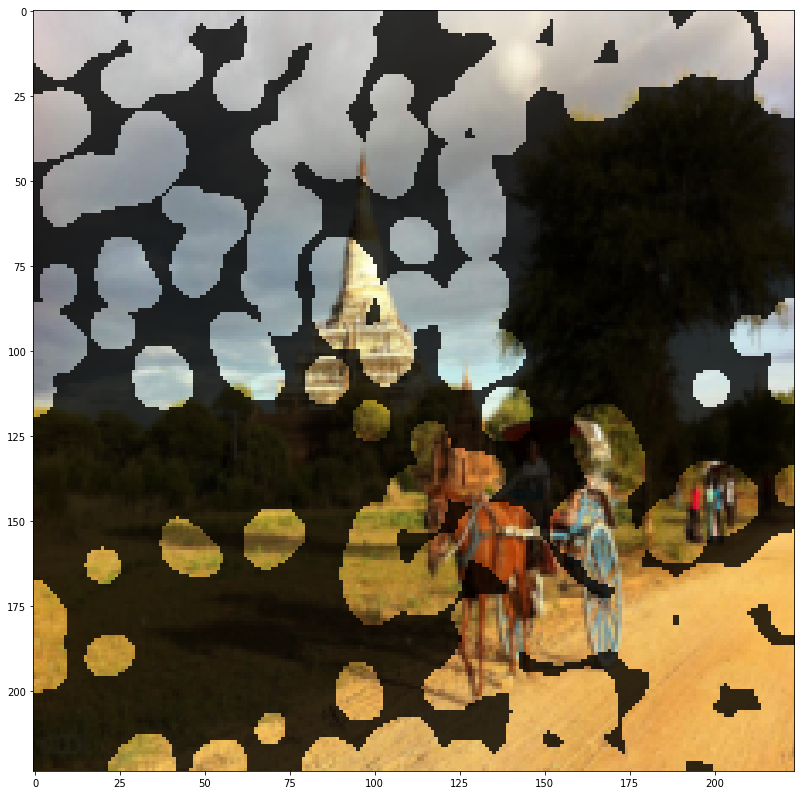

In [13]:
expl =(Explainer(model_imnet, 0,  AumannShapley())
  .for_absolute_qoi(horse_cart_class)
  .explain(instances))

interpreter = Interpreter()
interpreter.interpret_input(expl)

## PART II. Explanations for individual neurons

### Query 1 : What is most influential concept(feature map) in layer 16 on the image provided in horsecarts.npy(class 603)?
### Return  the  top  feature  map  index  and  visualize  the  top  neuron  in  the  corresponding feature map using interpretfeaturemap()

(1, 512)
[170]


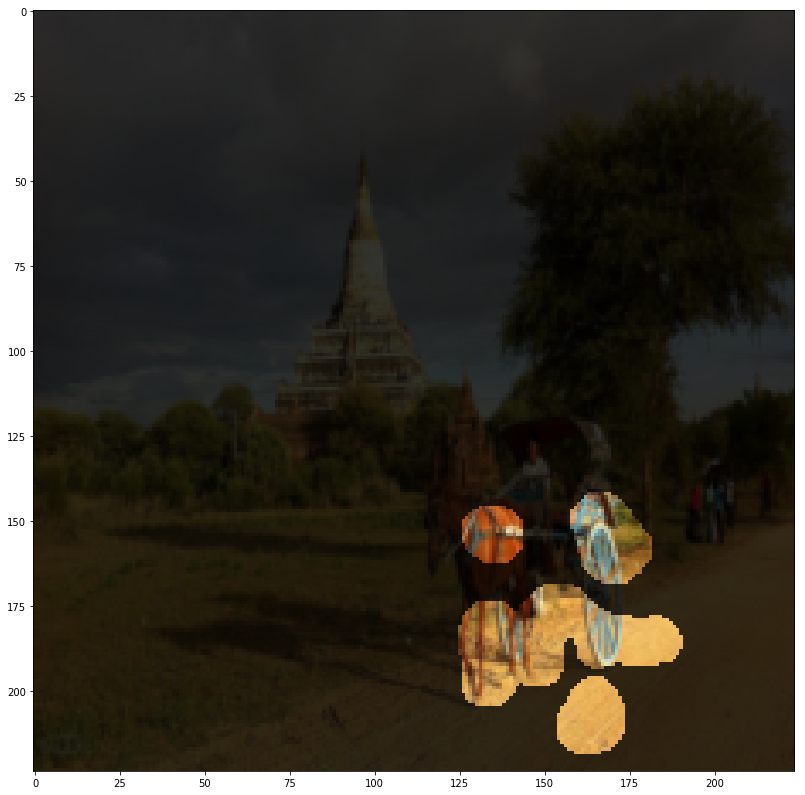

In [14]:
expl =(Explainer(model_imnet, 16,  AumannShapley())
  .for_absolute_qoi(horse_cart_class)
  .explain(instances))


maxInfluences = np.max(expl.influences, axis=(2,3))
maxInf = np.argmax(maxInfluences, axis=1)
print(maxInfluences.shape)
print(maxInf)

interpreter = Interpreter()
interpreter.interpret_feature_map(expl, maxInf)

## PART III. Comparative Quantity

In [5]:
sportscar_class = 817
convertible_class = 511

### Query 1 What is the most influential concept (feature map) in layer 13 for the sports car class?
### Query 2 What is the most influential concept (feature map) in layer 13 for the sports car class compared with convertible class?
### Visualization:For both queries, calculate your attributions using sportscars and convertibles and visualize neuron of maximum influence in the top feature map on 9 images in sportscars.
### Extra Credit


(9, 512)
149


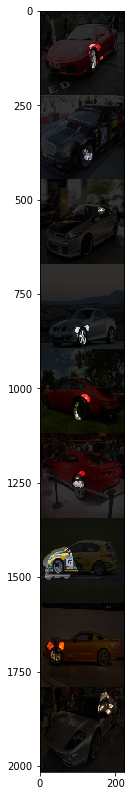

In [9]:
# 6.2.1 Most Influential feature map for Sportscar class
sports_car_instances = np.load('./data/get_sports_cars.npy')
expl =(Explainer(model_imnet, 14,  AumannShapley())
  .for_absolute_qoi(sportscar_class)
  .explain(sports_car_instances))


# sumInflunces = np.sum(expl.influences, axis=(2,3))
maxInfluences = np.max(expl.influences, axis=(2,3))
# This gives the most influential feature map across each instance. What we want is the most
# influential feature map across all instances, i.e., the mean across all 9 instances
maxInf = np.mean(maxInfluences, axis=0)
maxInf = np.argmax(maxInf, axis=0)
print(maxInfluences.shape)
print(maxInf)


interpreter = Interpreter()
interpreter.interpret_feature_map(expl, maxInf)

(9, 512)
21


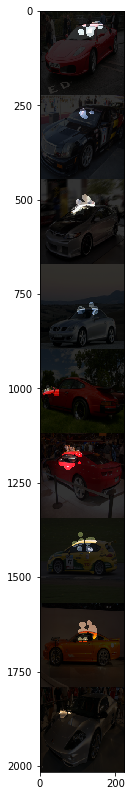

In [10]:
# 6.2.2 Most Influential feature map for Sportscar class compared to convertible

sports_car_instances = np.load('./data/get_sports_cars.npy')
conv_car_instances = np.load('./data/get_convertibles.npy')
expl =(Explainer(model_imnet, 14,  AumannShapley())
  .for_comparative_qoi(sportscar_class, convertible_class)
  .explain(sports_car_instances))

# sumInflunces = np.sum(expl.influences, axis=(2,3))
maxInfluences = np.max(expl.influences, axis=(2,3))
# This gives the most influential feature map across each instance. What we want is the most
# influential feature map across all instances, i.e., the mean across all 9 instances
maxInf = np.mean(maxInfluences, axis=0)
maxInf = np.argmax(maxInf, axis=0)
print(maxInfluences.shape)
print(maxInf)

interpreter = Interpreter()
interpreter.interpret_feature_map(expl, maxInf)

## PART IV. Model Compression

## 3(a)


In [1]:
# Class numbers
chainsaw_class = 491
bonnet_class = 452
park_bench_class = 703
sloth_bear_class = 297
pelican_class = 144


# Get insatnces
chainsaws_instances = np.load('./data/chainsaws.npy')
bonnet_instances = np.load('./data/bonnets.npy')
sloth_bear_instances = np.load('./data/sloth_bears.npy')
park_bench_instances = np.load('./data/sloth_bears.npy')
pelican_instances = np.load('./data/get_pelicans.npy')

def precision(true_pos,false_pos):
    return true_pos/float(true_pos+false_pos)

def recall(true_pos,false_neg):
    return true_pos/float(true_pos+false_neg)

def f1(precision,recall):
    return 2*precision*recall/float(precision + recall)


# Get first fully connected layer, as per instructions in paper
layer_number = 21

# Create explanations for Chainsaw class
expl =(Explainer(model_imnet, layer_number,  AumannShapley(resolution=2))
  .for_absolute_qoi(chainsaw_class)
  .explain(chainsaws_instances))

influences = expl.influences # Get the influences of the last layer
originalInf = np.mean(influences, axis=0) # Get the most influential neurons across all 77 instances in the class 

# Original weights
originalWeights = model_imnet.layers[layer_number].get_weights()[0] # Weights
originalBiases = model_imnet.layers[layer_number].get_weights()[1] # Biases


indxSortedMaximums = np.argpartition(originalInf, -1) # This is basically argmax but instead of the max argument when are returning index ordering of the all arguments
neuronNumbers = range(originalInf.shape[0])

# Create a 2D array to store F1 score numbers for all combinations of alpha and beta
all_f1_scores = np.zeros((11,12), dtype=float)

# Create a combination of best and worst performing neurons. From the top 1th neuron
# and bottom 0th neuron to the 2^11th neurons
for alpha in range (1, 2):
    numberOfAlphas = np.power(2, alpha)
    for beta in range (0, 2):
        numberOfBetas = np.power(2,beta)
        
        newWeights = np.copy(originalWeights)
        newBiases = np.copy(originalBiases)
        
        indexOfAlphas = indxSortedMaximums[-numberOfAlphas:]
        indexOfBetas = indxSortedMaximums[:numberOfBetas]
        indexesOfNeuronsOfInterest = np.setdiff1d(neuronNumbers, np.concatenate((indexOfAlphas, indexOfBetas)))
        
        newWeights[indexesOfNeuronsOfInterest] = 0
        model_imnet.layers[layer_number].set_weights([newWeights, originalBiases])
              
        # Create prdictions
        chainsaw_predictions = model_imnet.predict(chainsaws_instances).argmax(axis=1)
        bonnet_predictions = model_imnet.predict(bonnet_instances).argmax(axis=1)
        pelican_predictions = model_imnet.predict(pelican_instances).argmax(axis=1)
        sloth_bear_predictions = model_imnet.predict(sloth_bear_instances).argmax(axis=1)
        park_benches_predictions = model_imnet.predict(park_bench_instances).argmax(axis=1)        
        other_predictions = np.concatenate((bonnet_predictions, pelican_predictions, sloth_bear_predictions, park_benches_predictions))
  
        tp = sum(chainsaw_predictions == chainsaw_class)
        fn = sum(chainsaw_predictions != chainsaw_class)  
        fp = sum(other_predictions == chainsaw_class)
        
        precsn = precision(tp, fp)
        recll = recall(tp, fn)
        f1_score = f1(presn, recll)
        all_f1_scores[alpha, beta] = f1_score

        
# Reset model paramenters to the original   
model_imnet.layers[layer_number].set_weights([originalWeights, originalBiases])
# Plot heatmap
seaborn.heatmap(all_f1_scores)

NameError: name 'np' is not defined

In [50]:
chainsaws_instances = np.load('./data/chainsaws.npy')
bonnet_instances = np.load('./data/bonnets.npy')
sloth_bear_instances = np.load('./data/sloth_bears.npy')
park_bench_instances = np.load('./data/sloth_bears.npy')
pelican_instances = np.load('./data/get_pelicans.npy')


preds = model_imnet.predict(chainsaws_instances).argmax(axis=1)
bonnet_predictions = model_imnet.predict(bonnet_instances).argmax(axis=1)
pelican_predictions = model_imnet.predict(pelican_instances).argmax(axis=1)
sloth_bear_predictions = model_imnet.predict(sloth_bear_instances).argmax(axis=1)
park_benches_predictions = model_imnet.predict(park_bench_instances).argmax(axis=1)

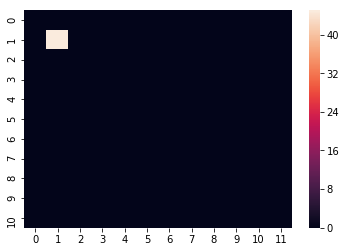

In [4]:
xx = np.zeros((11,12), dtype=float)
xx[1,1] = 45
seaborn.heatmap(xx)


## 3(b)